<a href="https://colab.research.google.com/github/imgsude/gsk/blob/main/Classification_Brain_Cancer_with_CNN_GSK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
orvile_brain_cancer_mri_dataset_path = kagglehub.dataset_download('orvile/brain-cancer-mri-dataset')

print('Data source import complete.')


Data source import complete.


In [219]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/brain-cancer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/orvile/brain-cancer-mri-dataset/versions/2


In [220]:
from google.colab import drive
import os
import shutil
import random
from tqdm import tqdm

drive.mount('/content/drive')

#  Kaggle API key bağlanma
drive_kaggle_json_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/kaggle.json"
kaggle_config_dir = "/root/.kaggle"

os.makedirs(kaggle_config_dir, exist_ok=True)

if not os.path.exists(drive_kaggle_json_path):
    raise FileNotFoundError(f"Dosya bulunamadı: {drive_kaggle_json_path}")

shutil.copy(drive_kaggle_json_path, kaggle_config_dir + "/kaggle.json")
os.chmod(kaggle_config_dir + "/kaggle.json", 0o600)

print("kaggle.json başarıyla yüklendi ve kullanıma hazır.")

# Veri Setini Bölme
original_dataset_dir = '/content/drive/MyDrive/Colab Notebooks/Brain_Cancer'
base_dir = '/content/brain-cancer-mri-dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

#Oranlar
train_split = 0.5
val_split = 0.25
test_split = 0.25

# Hedef klasörleri oluştur
for category in ['train', 'val', 'test']:
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(base_dir, category, class_name), exist_ok=True)

# Veri setini böl ve kopyala
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    total_images = len(images)
    train_count = int(total_images * train_split)
    val_count = int(total_images * val_split)

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    for image in tqdm(train_images, desc=f'Train - {class_name}'):
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

    for image in tqdm(val_images, desc=f'Val - {class_name}'):
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

    for image in tqdm(test_images, desc=f'Test - {class_name}'):
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

print("Veri seti başarıyla train, val ve test olarak bölündü.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
kaggle.json başarıyla yüklendi ve kullanıma hazır.


Test - brain_tumor: 100%|██████████| 512/512 [00:01<00:00, 351.12it/s]

Veri seti başarıyla train, val ve test olarak bölündü.


In [221]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [222]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augmentasyonlar
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,              # Dönme oranı
    width_shift_range=0.1,         # Genişlik kaydırması
    height_shift_range=0.1,        # Yükseklik kaydırması
    horizontal_flip=True,           # Yatay çevirme devam
    vertical_flip=False,            # İsteğe bağlı (MRI için genelde kapalı)
    zoom_range=0.1,                 #zoomlama orani
    fill_mode='nearest'             # Boşlukları doldurmak için kullandim
)

# Doğrulama ve test için sadece normalize etme kodu
datagen_val_test = ImageDataGenerator(rescale=1./255)

# Klasor Yolu
base_dir = 'brain-cancer-mri-dataset_split'

# Resimleri Yukle
train_generator = datagen_train.flow_from_directory(
    base_dir + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen_val_test.flow_from_directory(
    base_dir + '/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen_val_test.flow_from_directory(
    base_dir + '/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4070 images belonging to 3 classes.
Found 4017 images belonging to 3 classes.
Found 4020 images belonging to 3 classes.


In [223]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # 1. Blok
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # 2. Blok
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # 3. Blok
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # 4. Blok
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Küresel ortalama alma (Flatten yerine daha kararlı olabilir)
    layers.GlobalAveragePooling2D(),

    # Fully Connected
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),

    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 222, 222, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,019 (2.17 MB)

 Trainable params: 568,867 (2.17 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [224]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(train_generator, epochs=50,
          validation_data=val_generator,
          callbacks=[lr_scheduler, early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 126s 597ms/step - accuracy: 0.6195 - loss: 0.8231 - val_accuracy: 0.4949 - val_loss: 1.0310 - learning_rate: 1.0000e-05
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 69s 536ms/step - accuracy: 0.7810 - loss: 0.5144 - val_accuracy: 0.5031 - val_loss: 0.9298 - learning_rate: 1.0000e-05
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 67s 526ms/step - accuracy: 0.8382 - loss: 0.4268 - val_accuracy: 0.5031 - val_loss: 0.8773 - learning_rate: 1.0000e-05
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 67s 526ms/step - accuracy: 0.8469 - loss: 0.4018 - val_accuracy: 0.5663 - val_loss: 0.7184 - learning_rate: 1.0000e-05
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 615ms/step - accuracy: 0.8607 - loss: 0.3465 - val_accuracy: 0.7274 - val_loss: 0.5318 - learning_rate: 1.0000e-05
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 69s 537ms/step - accuracy: 0.8779 - loss: 0.3496 - val_accuracy: 0.7737 - val_loss: 0.5064 - learning_rate: 1.0000e-05
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 69s 5

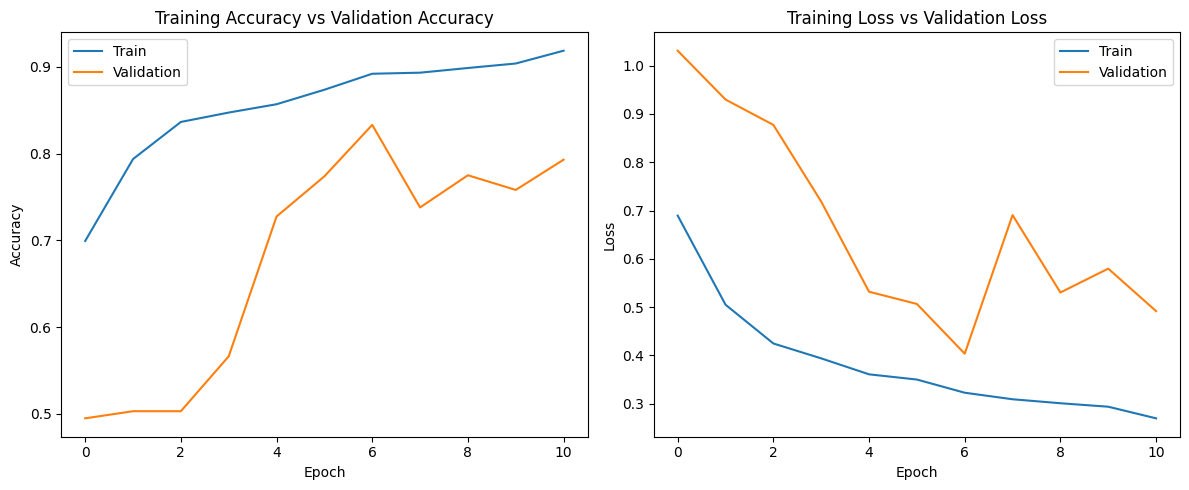

In [225]:
import matplotlib.pyplot as plt

# Dogruluk grafigi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafigi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step


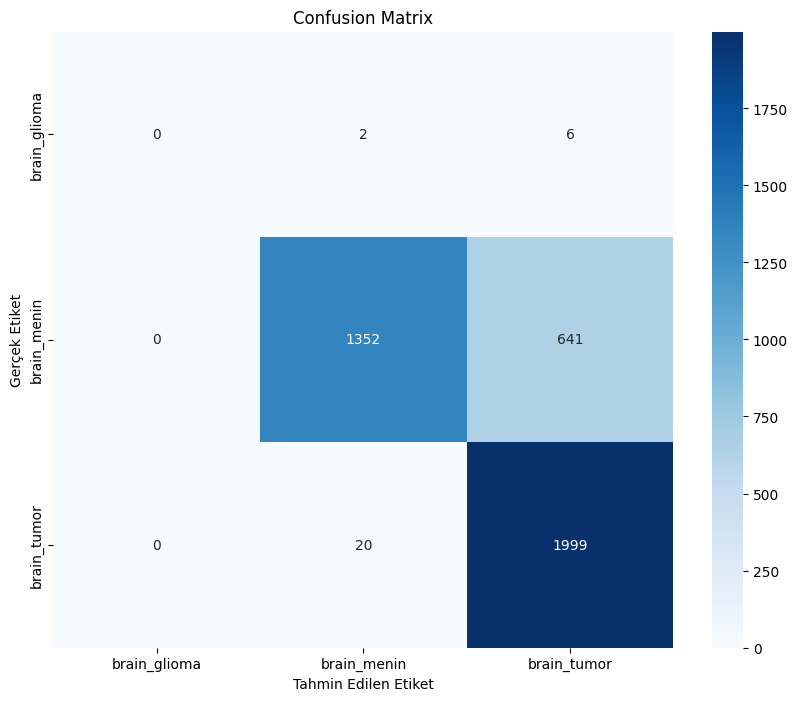

Classification Report:

              precision    recall  f1-score   support

brain_glioma       0.00      0.00      0.00         8
 brain_menin       0.98      0.68      0.80      1993
 brain_tumor       0.76      0.99      0.86      2019

    accuracy                           0.83      4020
   macro avg       0.58      0.56      0.55      4020
weighted avg       0.87      0.83      0.83      4020



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [226]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Test veri kümesinde tahmin yap
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion matrix oluştur
cm = confusion_matrix(y_true, y_pred)

# Confusion matrix görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()

# Classification report yazdır
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [227]:
print("Train sınıfları:", train_generator.class_indices)
print("Validation sınıfları:", val_generator.class_indices)


Train sınıfları: {'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}
Validation sınıfları: {'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


In [228]:
# Eğitim doğruluğunun değerlendirilmesi
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
print(f"Train Accuracy: {train_acc:.4f}")

# Doğrulama doğruluğunun değerlendirilmesi
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

# Test doğruluğunun değerlendirilmesi
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.8241
Validation Accuracy: 0.8330
Test Accuracy: 0.8336
